In [1]:
# standard imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Keras Imports
import keras 
import os, glob
import io

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, AveragePooling2D
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.applications import ResNet50
from keras.applications import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input  
from keras.preprocessing.image import img_to_array, array_to_img
from keras.utils import to_categorical

# pandas style
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

Using TensorFlow backend.


1. Create Train and Test 

In [2]:
test = pd.read_csv('../data/fashion-mnist_test.csv')
test.shape

(10000, 785)

In [3]:
train = pd.read_csv('../data/fashion-mnist_train.csv')
train.shape

(60000, 785)

In [4]:
image_rows = 28
image_cols = 28 
num_classes = 10 

In [5]:
# grab the train and test and split it up 
X_train = train.drop('label', axis=1)
y_train = train.loc[:, 'label']

X_test = test.drop('label', axis=1)
y_test = test.loc[:, 'label']
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [6]:
# Standardize the X_train and X_test
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [7]:
# change to 3 input channels (possibly do not need this for resnet)
X_train_resnet = np.dstack([X_train] * 3)
X_test_resnet = np.dstack([X_test]*3)
X_train_resnet.shape, X_test_resnet.shape


((60000, 784, 3), (10000, 784, 3))

In [8]:
# reshape the images
X_train_resnet = X_train_resnet.reshape(-1, 28,28,3)
X_test_resnet = X_test_resnet.reshape(-1, 28,28,3)
X_train_resnet.shape, X_test_resnet.shape


((60000, 28, 28, 3), (10000, 28, 28, 3))

In [9]:
# Resize the images width and height
X_train_resnet = np.asarray([img_to_array(array_to_img(image_x, scale=False).resize((32,32))) for image_x in X_train_resnet])
X_test_resnet = np.asarray([img_to_array(array_to_img(image_x, scale=False).resize((32,32))) for image_x in X_test_resnet])

#train_x = preprocess_input(x)
print(X_train_resnet.shape, X_test_resnet.shape)

(60000, 32, 32, 3) (10000, 32, 32, 3)


In [10]:
#input image dimensions
input_shape = X_train_resnet.shape[1:]
input_shape

(32, 32, 3)

In [11]:
# convert class vectors to binary class matrices using one hot encoding 
y_train_resnet = to_categorical(y_train, num_classes)
y_test_resnet = to_categorical(y_test, num_classes)
y_train_resnet.shape, y_test_resnet.shape

((60000, 10), (10000, 10))

In [12]:
# checked and the pixels are switched to categorical 
#y_train[:1]

In [13]:
# preprocessing inputs 
X_train_resV2_pp = preprocess_input(X_train_resnet)
X_test_resV2_pp = preprocess_input(X_test_resnet)
X_train_resV2_pp.shape, X_test_resV2_pp.shape

((60000, 32, 32, 3), (10000, 32, 32, 3))

2. Build Model

In [14]:
# bringing in the resnet50 model
resnet50_base_model = ResNet50(weights = 'imagenet', 
                          input_shape = input_shape, include_top = False)
resnet50_base_model.summary()

/Users/vivianahernandez/anaconda3/envs/uchi/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [15]:
# grab the output layer 
x = resnet50_base_model.output

# extend the layer 
x = AveragePooling2D(pool_size=(1,1))(x)

# flatten 
x = Flatten(name="flatten")(x)

# fully - connected layer 
x = Dense(units = 256, activation='relu')(x)

# adding a dropout 
x = Dropout(.5)(x)

# add final Dense layer with units = # classes (is the ouput layer)
predictions = Dense(units = 10, activation = 'softmax')(x)

In [16]:
# build the final resnet model 
resnet50_final = Model(inputs = resnet50_base_model.input, outputs = predictions)

In [17]:
# freeze the layes in the base model because we dont want to retrain them 
for layer in resnet50_base_model.layers:
    layer.trainable = False

In [18]:
# compile the final model
resnet50_final.compile(optimizer='adam', 
                       loss='categorical_crossentropy', metrics=['accuracy'])


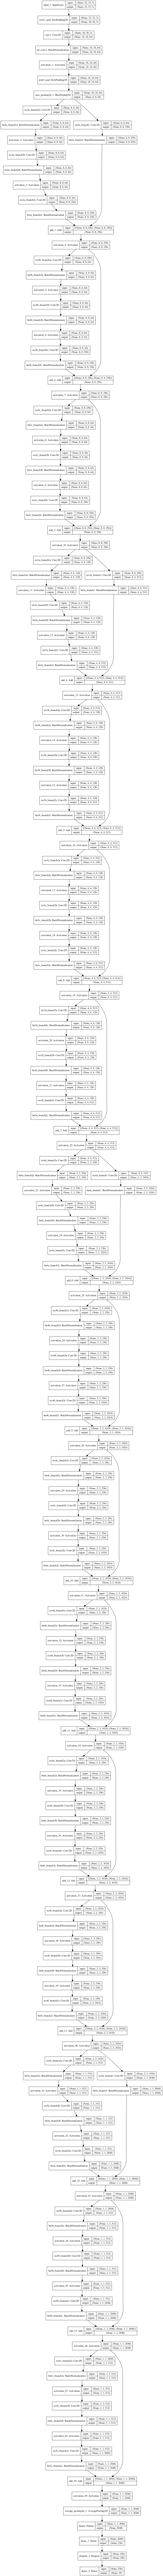

In [19]:
# create summary image of model
keras.utils.plot_model(resnet50_final, "resnet_v3_final_model.png", show_shapes=True)

3. Fit the Model

In [20]:
# fit the model 
batch_size = 32
epochs = 50
hist = resnet50_final.fit(X_train_resV2_pp, y_train_resnet, batch_size=batch_size, epochs=epochs)

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
# save the model 
resnet50_final.save('resnet50_final_may30_v3')

In [ ]:
# score the model 
scores = resnet50_final.evaluate(X_test_resV2_pp, y_test_resnet, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
# generate the predictions of the model 
preds_resnet50_final = resnet50_final.predict(X_test_resV2_pp)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = hist.history
loss_values = history_dict['loss']
#val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
#val_acc_values = history_dict['val_acc']
epochs = range(0, epochs)

plt.figure()
plt.plot(epochs, loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
plt.save_fig('Training Loss Resnet V3')

In [ ]:
plt.figure()
plt.plot(epochs, loss_values)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.show()
plt.save_fig('Training Accuracy V3')

In [ ]:
# plot the models history 
# history_dict = hist.history
# loss_values = history_dict['loss']
# val_loss_values = history_dict['val_loss']
# acc_values = history_dict['acc']
# val_acc_values = history_dict['val_acc']
# epochs = range(1, len(val_loss_values) + 1)


# plt.subplot(211)
# plt.plot(epochs, hist.history['loss'], 'ro', label='Training loss')
# plt.plot(epochs, val_loss_values, 'b', label='Test loss')
# plt.title('Training and test loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid('off')
# plt.show()
# plt.subplot(212)
# plt.plot(epochs, hist.history['acc'], 'ro', label='Training accuracy')
# plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
# plt.title('Training and test accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
# plt.legend()
# plt.grid('off')
# plt.show()